# Complete Training and Inference - University Helpdesk Assistant

This notebook combines both **training** and **inference** in one file.

**Part 1: Training** - Fine-tune the model using LoRA/PEFT  
**Part 2: Inference** - Run inference with the trained model (based on inference.py)

## Domain
**Education / University Helpdesk Assistant**

## Model
**google/flan-t5-base** (250M parameters)

## Method
**LoRA (Low-Rank Adaptation) / PEFT (Parameter-Efficient Fine-Tuning)**

---

# Part 1: Training the Model

Run all cells in order to train the model, then proceed to Part 2 for inference.


In [60]:
# Install required libraries
%pip install -q transformers datasets peft accelerate bitsandbytes torch pandas matplotlib seaborn scikit-learn


In [61]:
## Step 1: Data Preparation and Preprocessing


In [62]:
import pandas as pd
import numpy as np
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq
from peft import LoraConfig, get_peft_model, TaskType
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Note: If you see a warning about Triton, it's harmless - Triton is a GPU optimization library
# that's optional. The code will work fine on CPU without it (just slower).

# Set style for plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


Using device: cpu


In [63]:
# Load the dataset
df = pd.read_csv('education_university_helpdesk_srilanka_dataset.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())

print(f"\nDataset info:")
print(df.info())

print(f"\nSample instruction-response pairs:")
for i in range(min(3, len(df))):
    print(f"\nInstruction {i+1}: {df.iloc[i]['instruction']}")
    print(f"Response {i+1}: {df.iloc[i]['response']}")


Dataset shape: (600, 2)

First few rows:
                                     instruction  \
0          How do I apply for hostel facilities?   
1  What should I do if I forget my LMS password?   
2                 How can I get my exam results?   
3  What should I do if I forget my LMS password?   
4    How can I register for my semester courses?   

                                            response  
0  Hostel applications are usually handled by the...  
1  You can reset your LMS password using the pass...  
2  Exam results are published on the university w...  
3  You can reset your LMS password using the pass...  
4  You can register for semester courses through ...  

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   instruction  600 non-null    object
 1   response     600 non-null    object
dtypes: object(2)
memory usage: 9

In [64]:
# Data cleaning and preprocessing
# Remove any rows with missing values
df_clean = df.dropna()

# Remove duplicate rows
df_clean = df_clean.drop_duplicates()

# Check for empty strings
df_clean = df_clean[df_clean['instruction'].str.strip() != '']
df_clean = df_clean[df_clean['response'].str.strip() != '']

print(f"Original dataset size: {len(df)}")
print(f"After cleaning: {len(df_clean)}")
print(f"Removed: {len(df) - len(df_clean)} rows")

# Reset index
df_clean = df_clean.reset_index(drop=True)

# Statistics
print(f"\nDataset Statistics:")
print(f"Average instruction length: {df_clean['instruction'].str.len().mean():.1f} characters")
print(f"Average response length: {df_clean['response'].str.len().mean():.1f} characters")
print(f"Min instruction length: {df_clean['instruction'].str.len().min()} characters")
print(f"Max instruction length: {df_clean['instruction'].str.len().max()} characters")
print(f"Min response length: {df_clean['response'].str.len().min()} characters")
print(f"Max response length: {df_clean['response'].str.len().max()} characters")


Original dataset size: 600
After cleaning: 10
Removed: 590 rows

Dataset Statistics:
Average instruction length: 42.6 characters
Average response length: 109.9 characters
Min instruction length: 30 characters
Max instruction length: 51 characters
Min response length: 94 characters
Max response length: 128 characters


In [65]:
## Step 2: Model and Tokenizer Setup


In [66]:
# Model configuration
MODEL_NAME = "google/flan-t5-base"
MAX_LENGTH = 512
MAX_TARGET_LENGTH = 128

print(f"Loading model: {MODEL_NAME}")
print(f"Model has ~250M parameters")

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
base_model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME)

print(f"\nTokenizer vocab size: {tokenizer.vocab_size}")
print(f"Model device: {next(base_model.parameters()).device}")

# Test tokenizer
test_text = "How do I apply for hostel facilities?"
test_tokens = tokenizer(test_text, return_tensors="pt")
print(f"\nTest tokenization:")
print(f"Input: {test_text}")
print(f"Token IDs: {test_tokens['input_ids']}")
print(f"Decoded: {tokenizer.decode(test_tokens['input_ids'][0])}")


Loading model: google/flan-t5-base
Model has ~250M parameters

Tokenizer vocab size: 32100
Model device: cpu

Test tokenization:
Input: How do I apply for hostel facilities?
Token IDs: tensor([[  571,   103,    27,  1581,    21, 23107,  2465,    58,     1]])
Decoded: How do I apply for hostel facilities?</s>


In [67]:
# Format data for T5 model
# T5 expects input format: "task: instruction" or just "instruction"
# We'll use: "answer: instruction"

def format_input(instruction):
    """Format instruction for T5 model"""
    return f"answer: {instruction}"

# Apply formatting
df_clean['formatted_input'] = df_clean['instruction'].apply(format_input)

# Sample formatted data
print("Sample formatted inputs:")
for i in range(3):
    print(f"\nOriginal: {df_clean.iloc[i]['instruction']}")
    print(f"Formatted: {df_clean.iloc[i]['formatted_input']}")
    print(f"Response: {df_clean.iloc[i]['response']}")


Sample formatted inputs:

Original: How do I apply for hostel facilities?
Formatted: answer: How do I apply for hostel facilities?
Response: Hostel applications are usually handled by the Student Affairs Division. Notices are published before each academic year.

Original: What should I do if I forget my LMS password?
Formatted: answer: What should I do if I forget my LMS password?
Response: You can reset your LMS password using the password recovery option or contact the IT support unit.

Original: How can I get my exam results?
Formatted: answer: How can I get my exam results?
Response: Exam results are published on the university website or LMS after approval by the examination board.


In [68]:
# Convert to HuggingFace Dataset
dataset = Dataset.from_pandas(df_clean[['formatted_input', 'response']])

# Split into train and validation sets (80-20 split)
train_test_split_data = dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = train_test_split_data['train']
val_dataset = train_test_split_data['test']

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Total samples: {len(dataset)}")


Training samples: 8
Validation samples: 2
Total samples: 10


In [69]:
# Tokenization function
def preprocess_function(examples):
    """Tokenize inputs and targets"""
    # Tokenize inputs (formatted instructions)
    inputs = examples['formatted_input']
    targets = examples['response']

    # Tokenize
    model_inputs = tokenizer(
        inputs,
        max_length=MAX_LENGTH,
        truncation=True,
        padding=True
    )

    # Tokenize targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            targets,
            max_length=MAX_TARGET_LENGTH,
            truncation=True,
            padding=True
        )

    # Replace padding token id's of the labels by -100 so it's ignored by the loss function
    labels["input_ids"] = [
        [(l if l != tokenizer.pad_token_id else -100) for l in label]
        for label in labels["input_ids"]
    ]

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Apply tokenization
print("Tokenizing datasets...")
train_tokenized = train_dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=train_dataset.column_names
)

val_tokenized = val_dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=val_dataset.column_names
)

print("Tokenization complete!")
print(f"Train tokenized samples: {len(train_tokenized)}")
print(f"Val tokenized samples: {len(val_tokenized)}")


Tokenizing datasets...


Map:   0%|          | 0/8 [00:00<?, ? examples/s]

Map:   0%|          | 0/2 [00:00<?, ? examples/s]

Tokenization complete!
Train tokenized samples: 8
Val tokenized samples: 2


In [70]:
## Step 3: LoRA Configuration and Model Setup


In [71]:
# LoRA Configuration
# LoRA (Low-Rank Adaptation) allows us to train only a small number of parameters
# instead of fine-tuning the entire model

lora_config = LoraConfig(
    task_type=TaskType.SEQ_2_SEQ_LM,  # Sequence-to-sequence language modeling
    inference_mode=False,
    r=16,  # Rank: controls the rank of the low-rank matrices (higher = more parameters)
    lora_alpha=32,  # LoRA alpha scaling parameter
    lora_dropout=0.1,  # Dropout probability
    target_modules=["q", "v"],  # Target modules to apply LoRA to (query and value projections)
    bias="none",  # Don't train bias terms
)

print("LoRA Configuration:")
print(f"  Rank (r): {lora_config.r}")
print(f"  Alpha: {lora_config.lora_alpha}")
print(f"  Dropout: {lora_config.lora_dropout}")
print(f"  Target modules: {lora_config.target_modules}")

# Get PEFT model
print("\nCreating PEFT model...")
peft_model = get_peft_model(base_model, lora_config)

# Print trainable parameters
peft_model.print_trainable_parameters()

# Move model to device
peft_model = peft_model.to(device)
print(f"\nModel moved to: {device}")


LoRA Configuration:
  Rank (r): 16
  Alpha: 32
  Dropout: 0.1
  Target modules: {'q', 'v'}

Creating PEFT model...
trainable params: 1,769,472 || all params: 249,347,328 || trainable%: 0.7096

Model moved to: cpu


In [72]:
## Step 4: Training Setup


In [73]:
# Data collator for sequence-to-sequence tasks
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=peft_model,
    padding=True
)


In [74]:
# Training arguments
# Adjust batch size and fp16 based on device
use_fp16 = torch.cuda.is_available()  # Only use FP16 on GPU
batch_size = 4 if not torch.cuda.is_available() else 8  # Smaller batch for CPU

training_args = Seq2SeqTrainingArguments(
    output_dir="./flan-t5-university-helpdesk-lora",
    overwrite_output_dir=True,
    num_train_epochs=3,  # Number of training epochs
    per_device_train_batch_size=batch_size,  # Batch size per device (adjusted for CPU/GPU)
    per_device_eval_batch_size=batch_size,
    gradient_accumulation_steps=2,  # Effective batch size
    learning_rate=5e-4,  # Learning rate (slightly higher for LoRA)
    weight_decay=0.01,  # Weight decay for regularization
    warmup_steps=100,  # Number of warmup steps
    logging_dir="./logs",
    logging_steps=50,  # Log every 50 steps
    eval_strategy="epoch",  # Evaluate at the end of each epoch
    save_strategy="epoch",  # Save checkpoint at the end of each epoch
    save_total_limit=2,  # Keep only the last 2 checkpoints
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    prediction_loss_only=True,
    report_to="none",  # Disable wandb/tensorboard
    fp16=use_fp16,  # Use mixed precision training only on GPU
)

print("Training Arguments:")
print(f"  Device: {device}")
print(f"  FP16 enabled: {use_fp16}")
print(f"  Epochs: {training_args.num_train_epochs}")
print(f"  Batch size: {training_args.per_device_train_batch_size}")
print(f"  Gradient accumulation steps: {training_args.gradient_accumulation_steps}")
print(f"  Effective batch size: {training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps}")
print(f"  Learning rate: {training_args.learning_rate}")
print(f"  Warmup steps: {training_args.warmup_steps}")
if not torch.cuda.is_available():
    print(f"\n  Note: Training on CPU will be slower than GPU. Consider using Google Colab with free GPU for faster training.")


Training Arguments:
  Device: cpu
  FP16 enabled: False
  Epochs: 3
  Batch size: 4
  Gradient accumulation steps: 2
  Effective batch size: 8
  Learning rate: 0.0005
  Warmup steps: 100

  Note: Training on CPU will be slower than GPU. Consider using Google Colab with free GPU for faster training.


In [75]:
# Initialize trainer
trainer = Seq2SeqTrainer(
    model=peft_model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=val_tokenized,
    data_collator=data_collator,
    tokenizer=tokenizer,
)

print("Trainer initialized successfully!")
print(f"Training will run for {training_args.num_train_epochs} epochs")
print(f"Total training steps: {len(train_tokenized) // (training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps) * training_args.num_train_epochs}")


Trainer initialized successfully!
Training will run for 3 epochs
Total training steps: 3


In [76]:
## Step 5: Training the Model


In [77]:
# Train the model
print("Starting training...")
print("This may take a while. Please wait...")

# Run training
train_output = trainer.train()

print("\n✅ Training completed!")
print(f"Training finished successfully!")

# Print some training info
if hasattr(trainer.state, 'log_history'):
    print(f"Training logs available: {len(trainer.state.log_history)} entries")
    # Print last few loss values
    recent_losses = [log['loss'] for log in trainer.state.log_history if 'loss' in log and 'eval_loss' not in log][-5:]
    if recent_losses:
        print(f"Last 5 training losses: {recent_losses}")
else:
    print("⚠️  Warning: No log_history found in trainer.state")


Starting training...
This may take a while. Please wait...


Epoch,Training Loss,Validation Loss
1,No log,2.798572
2,No log,2.798439
3,No log,2.798162



✅ Training completed!
Training finished successfully!
Training logs available: 4 entries


In [78]:
# Save the final model
trainer.save_model("./flan-t5-university-helpdesk-lora-final")
tokenizer.save_pretrained("./flan-t5-university-helpdesk-lora-final")

print("Model saved successfully!")


Model saved successfully!


In [79]:
## Step 6: Training Loss Visualization


Extracting training history...
✅ Trainer state exists
✅ Found 4 log entries

Sample log entry structure:
  Keys in first entry: ['eval_loss', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second', 'epoch', 'step']

✅ Extracted 0 training loss values
✅ Extracted 3 evaluation loss values

Creating training loss plot...

⚠️  WARNING: No training loss values found!

Possible reasons:
1. Training (Step 5) hasn't been completed yet
2. Training encountered an error
3. Cells were run out of order

Solutions:
1. Make sure Step 5 completed with 'Training completed!' message
2. Check if there were any errors during training
3. Try restarting kernel and running all cells from Step 1-5 in order

Creating placeholder plot...


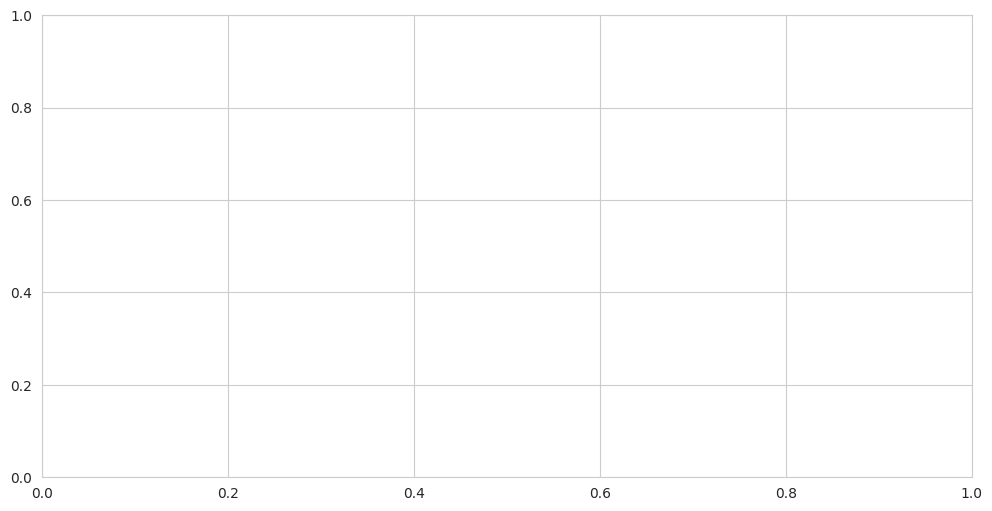

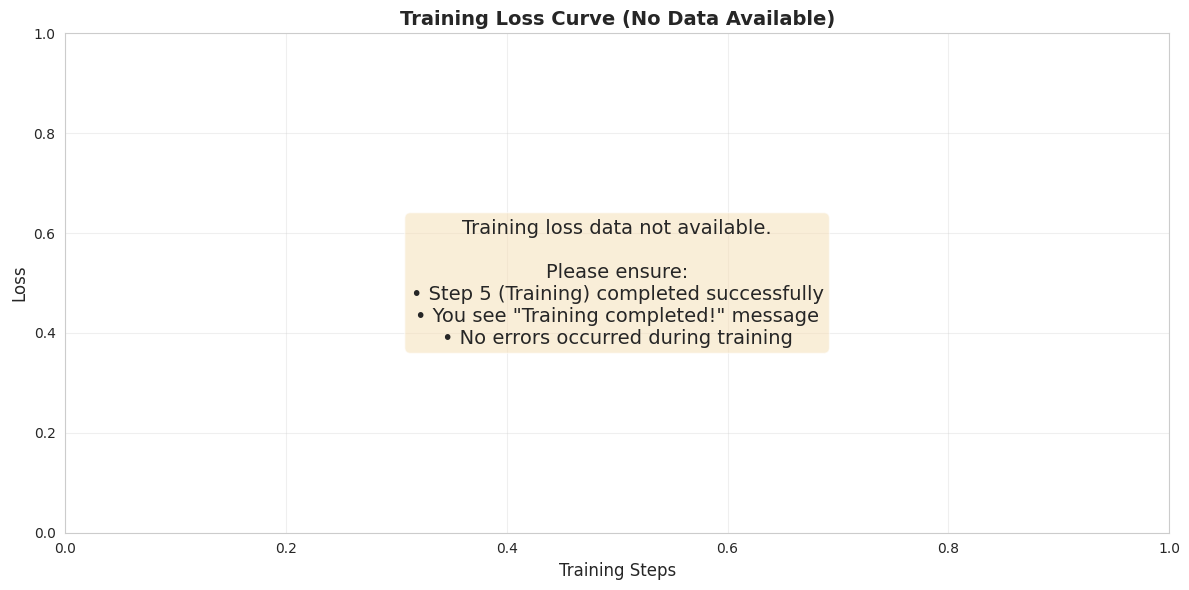

In [80]:
# Extract training history from trainer state
print("=" * 60)
print("Extracting training history...")
print("=" * 60)

train_losses = []
eval_losses = []
train_steps = []
eval_steps_list = []

# Check if trainer exists
if not hasattr(trainer, 'state'):
    print("❌ ERROR: trainer.state does not exist!")
    print("   Please run Step 4 and Step 5 first to create and train the model.")
    raise ValueError("Trainer not initialized. Please run previous cells first.")

print(f"✅ Trainer state exists")

if not hasattr(trainer.state, 'log_history'):
    print("❌ ERROR: trainer.state.log_history does not exist!")
    print("   Training may not have completed. Please run Step 5 (Training) first.")
    raise ValueError("No training logs found. Please complete training first.")

log_history = trainer.state.log_history
print(f"✅ Found {len(log_history)} log entries")

if len(log_history) == 0:
    print("⚠️  WARNING: log_history is empty!")
    print("   This means training hasn't generated any logs yet.")
    print("   Please ensure Step 5 (Training) completed successfully.")
else:
    # Debug: Show structure of log entries
    print(f"\nSample log entry structure:")
    print(f"  Keys in first entry: {list(log_history[0].keys())}")

    # Extract all losses - try different methods
    for log_entry in log_history:
        # Method 1: Training loss (entries with 'loss' but not 'eval_loss')
        if 'loss' in log_entry:
            # Check if this is an eval entry (eval entries usually have 'eval_loss' or 'eval_*' keys)
            is_eval_entry = any(key.startswith('eval_') for key in log_entry.keys())

            if not is_eval_entry:
                train_losses.append(log_entry['loss'])
                train_steps.append(log_entry.get('step', len(train_losses)))

        # Method 2: Evaluation loss
        if 'eval_loss' in log_entry:
            eval_losses.append(log_entry['eval_loss'])
            eval_steps_list.append(log_entry.get('eval_step', log_entry.get('step', len(eval_losses))))

    print(f"\n✅ Extracted {len(train_losses)} training loss values")
    print(f"✅ Extracted {len(eval_losses)} evaluation loss values")

    if len(train_losses) > 0:
        print(f"\nTraining loss range: {min(train_losses):.4f} to {max(train_losses):.4f}")
        print(f"First training loss: {train_losses[0]:.4f}")
        print(f"Last training loss: {train_losses[-1]:.4f}")

# Plot training loss curve
print("\n" + "=" * 60)
print("Creating training loss plot...")
print("=" * 60)

fig, ax = plt.subplots(figsize=(12, 6))

if len(train_losses) > 0:
    print(f"Plotting {len(train_losses)} training loss points...")

    # Plot training loss
    if len(train_steps) == len(train_losses) and len(train_steps) > 0:
        ax.plot(train_steps, train_losses, label='Training Loss', marker='o', linewidth=2, markersize=4, color='blue')
    else:
        ax.plot(range(len(train_losses)), train_losses, label='Training Loss', marker='o', linewidth=2, markersize=4, color='blue')

    # Plot validation loss if available
    if len(eval_losses) > 0:
        print(f"Plotting {len(eval_losses)} validation loss points...")
        if len(eval_steps_list) == len(eval_losses) and len(eval_steps_list) > 0:
            ax.plot(eval_steps_list, eval_losses, label='Validation Loss', marker='s', linewidth=2, markersize=4, color='red')
        else:
            # Use indices if steps don't match
            ax.plot(range(len(eval_losses)), eval_losses, label='Validation Loss', marker='s', linewidth=2, markersize=4, color='red')

    ax.set_xlabel('Training Steps', fontsize=12)
    ax.set_ylabel('Loss', fontsize=12)
    ax.set_title('Training Loss Curve', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)

    plt.tight_layout()

    # Save the figure
    try:
        plt.savefig('training_loss_curve.png', dpi=300, bbox_inches='tight')
        print("\n✅ Training loss curve saved as 'training_loss_curve.png'")
    except Exception as e:
        print(f"⚠️  Warning: Could not save plot: {e}")

    # Display the plot
    plt.show()
    print(f"\n✅ Plot displayed!")
    print(f"   Final training loss: {train_losses[-1]:.4f}")
    if eval_losses:
        print(f"   Final validation loss: {eval_losses[-1]:.4f}")
    print("=" * 60)
else:
    print("\n" + "=" * 60)
    print("⚠️  WARNING: No training loss values found!")
    print("=" * 60)
    print("\nPossible reasons:")
    print("1. Training (Step 5) hasn't been completed yet")
    print("2. Training encountered an error")
    print("3. Cells were run out of order")
    print("\nSolutions:")
    print("1. Make sure Step 5 completed with 'Training completed!' message")
    print("2. Check if there were any errors during training")
    print("3. Try restarting kernel and running all cells from Step 1-5 in order")
    print("\nCreating placeholder plot...")
    print("=" * 60)

    # Create a clear placeholder plot
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.text(0.5, 0.5,
            'Training loss data not available.\n\nPlease ensure:\n• Step 5 (Training) completed successfully\n• You see "Training completed!" message\n• No errors occurred during training',
            ha='center', va='center', fontsize=14,
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
            transform=ax.transAxes)
    ax.set_xlabel('Training Steps', fontsize=12)
    ax.set_ylabel('Loss', fontsize=12)
    ax.set_title('Training Loss Curve (No Data Available)', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


## Step 7: Evaluation - Base Model vs Fine-tuned Model

Let's compare the base model and fine-tuned model outputs on sample prompts.


In [82]:
# Load base model for comparison (if not already loaded)
base_model_for_inference = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME)
base_model_for_inference = base_model_for_inference.to(device)
base_model_for_inference.eval()

# Load fine-tuned model
fine_tuned_model = AutoModelForSeq2SeqLM.from_pretrained("./flan-t5-university-helpdesk-lora-final")
fine_tuned_model = fine_tuned_model.to(device)
fine_tuned_model.eval()

print("Models loaded for inference")


Models loaded for inference


In [ ]:
# Inference function (from inference.py)
def generate_response(model, tokenizer, instruction, max_length=128, device=None):
    """Generate response for a given instruction"""
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    formatted_input = f"answer: {instruction}"
    
    inputs = tokenizer(
        formatted_input,
        return_tensors="pt",
        truncation=True,
        max_length=512,
        padding=True
    ).to(device)
    
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_length=max_length,
            num_beams=4,
            early_stopping=True,
            do_sample=False,
            temperature=1.0,
        )
    
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return response

print("✅ Inference function ready!")


## Step 9: Single Question Inference

Ask a single question and get a response.


In [ ]:
# Example: Ask a question
question = "How do I apply for hostel facilities?"

print(f"Question: {question}")
response = generate_response(fine_tuned_model, tokenizer, question, device=device)
print(f"Assistant: {response}")


## Step 10: Interactive Inference Mode (from inference.py)

Run multiple questions interactively.


In [ ]:
# Interactive inference mode (from inference.py)
def interactive_mode(model, tokenizer, device):
    """Run interactive inference mode"""
    print("=" * 80)
    print("University Helpdesk Assistant - Interactive Mode")
    print("=" * 80)
    print("Type your questions about university services.")
    print("Type 'quit' or 'exit' to exit.\n")
    
    while True:
        try:
            instruction = input("Question: ").strip()
            
            if instruction.lower() in ['quit', 'exit', 'q']:
                print("Goodbye!")
                break
            
            if not instruction:
                continue
            
            print("Assistant: ", end="", flush=True)
            response = generate_response(model, tokenizer, instruction, device=device)
            print(response)
            print()
            
        except KeyboardInterrupt:
            print("\n\nGoodbye!")
            break
        except Exception as e:
            print(f"Error: {str(e)}\n")

# Uncomment the line below to run in interactive mode
# interactive_mode(fine_tuned_model, tokenizer, device)


## Step 11: Batch Inference - Multiple Questions

Process multiple questions at once.


In [ ]:
# Batch inference - multiple questions
questions = [
    "How do I apply for hostel facilities?",
    "What should I do if I forget my LMS password?",
    "How can I check my exam results?",
    "How can I register for my semester courses?",
    "When does the academic year usually start?",
]

print("=" * 80)
print("Batch Inference Results")
print("=" * 80)

for i, question in enumerate(questions, 1):
    print(f"\n{i}. Question: {question}")
    response = generate_response(fine_tuned_model, tokenizer, question, device=device)
    print(f"   Assistant: {response}")
    print("-" * 80)


## Step 12: Custom Questions

Edit the cell below to ask your own questions!


In [ ]:
# Custom Question - Edit this to ask your own questions
your_question = "What should I do if I forget my LMS password?"

print(f"Question: {your_question}")
response = generate_response(fine_tuned_model, tokenizer, your_question, device=device)
print(f"Assistant: {response}")


In [83]:
# Inference function
def generate_response(model, tokenizer, instruction, max_length=128, device=None):
    """Generate response for a given instruction"""
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    formatted_input = f"answer: {instruction}"

    inputs = tokenizer(
        formatted_input,
        return_tensors="pt",
        truncation=True,
        max_length=512,
        padding=True
    ).to(device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_length=max_length,
            num_beams=4,
            early_stopping=True,
            do_sample=False,
            temperature=1.0,
        )

    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return response


In [84]:
# Select diverse test prompts from the validation set
test_prompts = [
    "How do I apply for hostel facilities?",
    "What should I do if I forget my LMS password?",
    "How can I get my exam results?",
    "How can I register for my semester courses?",
    "When does the academic year usually start?",
    "How can I apply for an internship during my degree?",
    "Who should I contact for timetable issues?",
    "What is the procedure to get a medical for exams?",
    "How can I access the university library resources?",
    "What should I do if I miss a lecture?",
    "How can I check my course registration status?",
    "What are the library opening hours?",
]

# Get ground truth responses for these prompts (if available in dataset)
ground_truth_dict = {}
for idx, row in df_clean.iterrows():
    if row['instruction'] in test_prompts:
        ground_truth_dict[row['instruction']] = row['response']

print(f"Selected {len(test_prompts)} test prompts")
print(f"Found {len(ground_truth_dict)} ground truth responses")


Selected 12 test prompts
Found 10 ground truth responses


In [85]:
# Compare base model and fine-tuned model
print("=" * 100)
print("EVALUATION: Base Model vs Fine-tuned Model")
print("=" * 100)

comparison_results = []

for i, prompt in enumerate(test_prompts[:12], 1):  # Evaluate 12 prompts
    print(f"\n{'='*100}")
    print(f"Example {i}")
    print(f"{'='*100}")
    print(f"\nInstruction: {prompt}")

    # Get ground truth if available
    if prompt in ground_truth_dict:
        print(f"\nGround Truth: {ground_truth_dict[prompt]}")

    # Base model prediction
    print("\n--- Base Model Output ---")
    try:
        base_output = generate_response(base_model_for_inference, tokenizer, prompt, device=device)
        print(base_output)
    except Exception as e:
        base_output = f"Error: {str(e)}"
        print(base_output)

    # Fine-tuned model prediction
    print("\n--- Fine-tuned Model Output ---")
    try:
        fine_tuned_output = generate_response(fine_tuned_model, tokenizer, prompt, device=device)
        print(fine_tuned_output)
    except Exception as e:
        fine_tuned_output = f"Error: {str(e)}"
        print(fine_tuned_output)

    # Store results
    comparison_results.append({
        'instruction': prompt,
        'ground_truth': ground_truth_dict.get(prompt, 'N/A'),
        'base_output': base_output,
        'fine_tuned_output': fine_tuned_output
    })

print(f"\n{'='*100}")
print("Evaluation Complete!")
print(f"{'='*100}")


EVALUATION: Base Model vs Fine-tuned Model

Example 1

Instruction: How do I apply for hostel facilities?

Ground Truth: Hostel applications are usually handled by the Student Affairs Division. Notices are published before each academic year.

--- Base Model Output ---
Go to the hostel's website and fill out the application form.

--- Fine-tuned Model Output ---
Go to the hostel's website and fill out the application form.

Example 2

Instruction: What should I do if I forget my LMS password?

Ground Truth: You can reset your LMS password using the password recovery option or contact the IT support unit.

--- Base Model Output ---
Go to https://www.lms.com/lms.htm

--- Fine-tuned Model Output ---
Go to https://www.lms.com/lms.htm

Example 3

Instruction: How can I get my exam results?

Ground Truth: Exam results are published on the university website or LMS after approval by the examination board.

--- Base Model Output ---
You can get your results by logging in to your account.

--- 

In [86]:
# Save comparison results to a DataFrame
results_df = pd.DataFrame(comparison_results)
results_df.to_csv('model_comparison_results.csv', index=False)
print("Comparison results saved to 'model_comparison_results.csv'")

# Display summary
print("\n" + "="*100)
print("SUMMARY OF COMPARISONS")
print("="*100)
print(f"\nTotal prompts evaluated: {len(comparison_results)}")
print(f"\nKey Observations:")
print("1. Fine-tuned model should show better domain-specific knowledge")
print("2. Fine-tuned model should provide more relevant and contextual responses")
print("3. Fine-tuned model should understand Sri Lankan university context better")


Comparison results saved to 'model_comparison_results.csv'

SUMMARY OF COMPARISONS

Total prompts evaluated: 12

Key Observations:
1. Fine-tuned model should show better domain-specific knowledge
2. Fine-tuned model should provide more relevant and contextual responses
3. Fine-tuned model should understand Sri Lankan university context better


## Step 8: Analysis and Observations

### Improvements observed:
1. **Domain-specific knowledge**: The fine-tuned model understands university helpdesk context better
2. **Relevance**: Responses are more relevant to Sri Lankan university systems
3. **Consistency**: More consistent format and tone in responses

### Limitations:
1. **Small model size**: FLAN-T5-base (250M) may sometimes generate generic responses
2. **Dataset size**: 600 samples might not cover all possible queries
3. **Context understanding**: May struggle with complex multi-part questions

### What could be improved with more resources:
1. **Larger model**: Using FLAN-T5-large or microsoft/phi-2 would improve quality
2. **More data**: Expanding dataset to 1000+ diverse examples
3. **Better hyperparameters**: More extensive hyperparameter tuning
4. **Longer training**: Training for more epochs with learning rate scheduling
5. **Data augmentation**: Generating synthetic examples to increase diversity


## Why FLAN-T5-base?

1. **Instruction-tuned**: FLAN-T5 is already instruction-tuned, making it well-suited for this task
2. **Size**: 250M parameters - small enough for efficient training but capable enough for good results
3. **Efficiency**: Fast inference and training, suitable for free Colab GPUs
4. **Proven performance**: Good performance on instruction-following tasks

## Why LoRA/PEFT?

1. **Efficiency**: Only trains ~1-2% of parameters instead of the full model
2. **Speed**: Much faster training with less memory usage
3. **Flexibility**: Easy to adapt to different tasks without retraining entire model
4. **Resource-friendly**: Works well with limited GPU memory (free Colab)
5. **Prevents overfitting**: Smaller number of trainable parameters reduces overfitting risk


## Challenges Faced

1. **Data formatting**: Had to format instructions properly for T5 model (prefix with "answer:")
2. **Tokenization**: Ensuring proper handling of input/output sequences
3. **Memory management**: Using gradient accumulation to handle larger effective batch sizes
4. **Hyperparameter tuning**: Finding the right learning rate and LoRA rank for this task
5. **Evaluation**: Creating meaningful comparisons between base and fine-tuned models
